<a href="https://colab.research.google.com/github/Pr454th/Deep-Learning/blob/main/Twitter_Sentiment_Analysis_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SENTIMENT ANALYSIS USING LSTM
3 Jan 2023

<div class="alert alert-block alert-danger">  
<h2>Importing Python Libraries</h2>
        
</div>

In [106]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


<div class="alert alert-block alert-danger">  
<h2><strong>Loading the data</strong></h2>
        
</div>

In [107]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]

<div class="alert alert-block alert-danger">  
<h2>Exploratory data analysis </h2>


        
</div>

#### Five top records of data

In [108]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


#### Five last records of data

In [109]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


#### Coloumns/features in data

In [110]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

#### Length of data

In [111]:
print('lenght of data is', len(data))

lenght of data is 1599999


#### Shape of data

In [112]:
data.shape

(1599999, 6)

#### Data information

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


#### Data types of all coloumns

In [114]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

#### Checking Null values

In [115]:
np.sum(data.isnull().any(axis=1))

0

#### Rows and columns in the dataset

In [116]:
print('Count of columns in the data is:  ', len(data.columns))

Count of columns in the data is:   6


In [117]:
print('Count of rows in the data is:  ', len(data))

Count of rows in the data is:   1599999


#### Selecting the text and label coloumn

In [118]:
data=data[['text','label']]

#### Assigning 1 to Positive sentment 4

In [119]:
data['label'][data['label']==4]=1

#### Separating positive and negative tweets

In [120]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

#### taking one fourth data so we can run on our machine easily 

In [121]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

#### Combining positive and negative tweets

In [122]:
data = pd.concat([data_pos, data_neg])

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Making statement text in lower case

In [124]:
data['text']=data['text'].str.lower()

In [125]:
data['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now .. i hate you damn h...
19997    geez,i hv to read the whole book of personalit...
19998    i threw my sign at donnie and he bent over to ...
19999    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

#### Cleaning and removing Stop words of english

In [126]:
stopwords_list = stopwords.words('english')

In [127]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

#### Cleaning and removing the above stop words list from the tweet text

In [128]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

#### Cleaning and removing punctuations 

In [129]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [130]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998     threw sign donnie bent get thingee made sad face
19999    heather2711 good thing find none ones like com...
Name: text, dtype: object

#### Cleaning and removing repeating characters

In [131]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [132]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

#### Cleaning and removing email

In [133]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [134]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

#### Cleaning and removing URL's

In [135]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [136]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

#### Cleaning and removing Numeric numbers

In [137]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [138]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather god thing find none ones like come siz...
Name: text, dtype: object

#### Getting tokenization of tweet text

In [139]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [140]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

#### Applying Stemming

In [141]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [142]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

#### Applying Lemmatizer

In [143]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

In [144]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

<b> <h3> Inputs : </h3></b>  Inputs are the data that we feed into machine learning like in this project tweets texts are the inputs. 

<b> <h3> Training Data </h3></b>  We use training data when we train the models. We feed train data to machine learning and deep learning models so that model can learn from the data.

<b> <h3> Validation Data </h3></b>  We use validation data while training the model. We use this data to evalaute the performance that how the model perform on training time.

####  Separating input feature and label

In [145]:
X=data.text
y=data.label

#### Preparing the input features for training 

In [146]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

As we can see that there total 40000 tweets and the number words/features are 500.

In [147]:
sequences_matrix.shape

(40000, 500)

#### Separating the 70% data for training data and 30% for testing data

In [148]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

<div class="alert alert-block alert-danger">  
<h2>Implementing Tensorflow based model for training</h2>   
</div>

In [149]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

# Model compilation

In [150]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  

In [151]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/6
315/315 [==============================] - 124s 383ms/step - loss: 0.5740 - accuracy: 0.6956 - val_loss: 0.5268 - val_accuracy: 0.7393
Epoch 2/6
315/315 [==============================] - 117s 371ms/step - loss: 0.5021 - accuracy: 0.7577 - val_loss: 0.5177 - val_accuracy: 0.7389
Epoch 3/6
315/315 [==============================] - 121s 385ms/step - loss: 0.5907 - accuracy: 0.7163 - val_loss: 0.5303 - val_accuracy: 0.7346
Epoch 4/6
315/315 [==============================] - 119s 377ms/step - loss: 0.4921 - accuracy: 0.7625 - val_loss: 0.5207 - val_accuracy: 0.7418
Epoch 5/6
315/315 [==============================] - 120s 382ms/step - loss: 0.4921 - accuracy: 0.7615 - val_loss: 0.5234 - val_accuracy: 0.7443
Epoch 6/6
315/315 [==============================] - 119s 377ms/step - loss: 0.4690 - accuracy: 0.7744 - val_loss: 0.5259 - val_accuracy: 0.7400
Training finished !!


#### Testing the Trained model on test data

In [152]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

375/375 [==============================] - 24s 63ms/step - loss: 0.5254 - accuracy: 0.7401


#### Accuracy

In [153]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.74


#### Getting prediction of the test data and then we will compare the true labels/classes of the data with predictions

In [154]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 

375/375 [==============================] - 24s 63ms/step


#### Confusion matrix



confusion matrix


[[4002 2007]
 [1112 4879]]




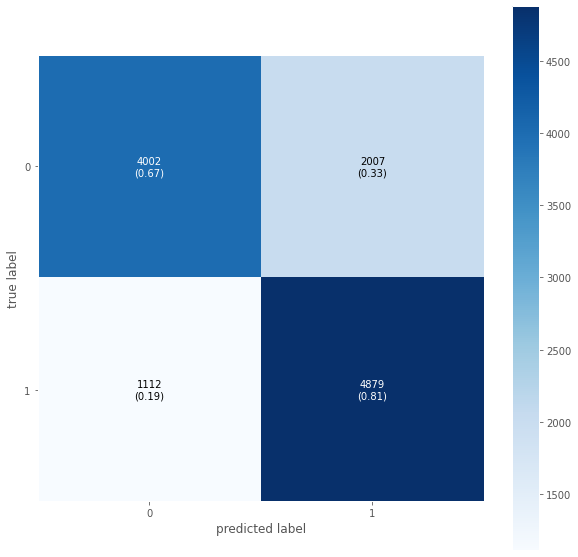

In [155]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# ROC CURVE

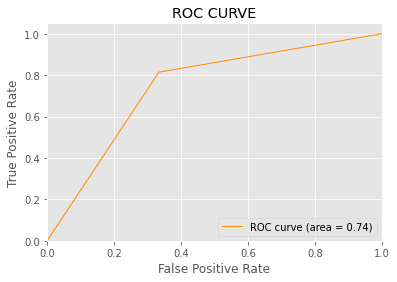

In [156]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()



